# Algorithmic Trading Model for Exponential Moving Average Crossover Grid Search
### David Lowe
### June 25, 2020

## Task 1. Prepare Environment

In [1]:
!pip install python-dotenv PyMySQL

In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [3]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = True

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = True
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# pd.set_option("display.width", 140)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
stock_symbol = 'ZM'
initial_capital = 0

# Specify the parameters for the trading strategy
fast_ma_min = 5
fast_ma_max = 20
slow_ma_min = 10
slow_ma_max = 50
ma_increment = 5
min_ma_gap = 5

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(slow_ma_max*1.5)) # Need more pricing data to calculate moving averages

model_end_date = datetime.now()
model_end_date = datetime(2020, 6, 29)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-06-29 00:00:00


## Task 2. Acquire and Pre-Process Data

In [6]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [7]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [8]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')
if verbose: print(quandl_dict)

302 data points retrieved from the API call.
{'datatable': {'data': [['ZM', '2020-06-29', 254.97, 255.9, 243.59, 248.56, 8353674.0, 0.0, 248.56, '2020-06-29'], ['ZM', '2020-06-26', 260.52, 261.62, 250.36, 256.8, 17142899.0, 0.0, 256.8, '2020-06-26'], ['ZM', '2020-06-25', 258.23, 260.29, 252.66, 259.51, 7409003.0, 0.0, 259.51, '2020-06-25'], ['ZM', '2020-06-24', 254.5, 258.75, 248.6, 255.9, 9832986.0, 0.0, 255.9, '2020-06-24'], ['ZM', '2020-06-23', 251.26, 254.775, 247.57, 252.81, 8791498.0, 0.0, 252.81, '2020-06-25'], ['ZM', '2020-06-22', 247.465, 254.9, 247.29, 251.27, 11058790.0, 0.0, 251.27, '2020-06-23'], ['ZM', '2020-06-19', 241.64, 243.57, 238.703, 243.48, 10077543.0, 0.0, 243.48, '2020-06-19'], ['ZM', '2020-06-18', 240.39, 242.61, 238.22, 241.57, 9297645.0, 0.0, 241.57, '2020-06-18'], ['ZM', '2020-06-17', 243.18, 243.88, 235.12, 236.76, 11704326.0, 0.0, 236.76, '2020-06-17'], ['ZM', '2020-06-16', 235.99, 243.5, 231.821, 242.56, 11299942.0, 0.0, 242.56, '2020-06-16'], ['ZM', '202

In [9]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2019-04-18 to 2020-06-29
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       302 non-null    object 
 1   date         302 non-null    object 
 2   open         302 non-null    float64
 3   high         302 non-null    float64
 4   low          302 non-null    float64
 5   close        302 non-null    float64
 6   volume       302 non-null    float64
 7   dividend     302 non-null    float64
 8   closeunadj   302 non-null    float64
 9   lastupdated  302 non-null    object 
dtypes: float64(7), object(3)
memory usage: 26.0+ KB


In [10]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2019-04-18,ZM,2019-04-18,65.00,66.000,60.321,62.0,25764659.0,0.0,62.0,2020-05-01
2019-04-22,ZM,2019-04-22,61.00,68.900,59.940,65.7,9949738.0,0.0,65.7,2020-05-01
2019-04-23,ZM,2019-04-23,66.87,74.169,65.550,69.0,6786513.0,0.0,69.0,2020-05-01
2019-04-24,ZM,2019-04-24,71.40,71.500,63.160,63.2,4973529.0,0.0,63.2,2020-05-01
2019-04-25,ZM,2019-04-25,64.74,66.850,62.600,65.0,3863275.0,0.0,65.0,2020-05-01


In [11]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-06-23,ZM,2020-06-23,251.26,254.775,247.57,252.81,8791498.0,0.0,252.81,2020-06-25
2020-06-24,ZM,2020-06-24,254.50,258.750,248.60,255.90,9832986.0,0.0,255.90,2020-06-24
2020-06-25,ZM,2020-06-25,258.23,260.290,252.66,259.51,7409003.0,0.0,259.51,2020-06-25
2020-06-26,ZM,2020-06-26,260.52,261.620,250.36,256.80,17142899.0,0.0,256.80,2020-06-26
2020-06-29,ZM,2020-06-29,254.97,255.900,243.59,248.56,8353674.0,0.0,248.56,2020-06-29


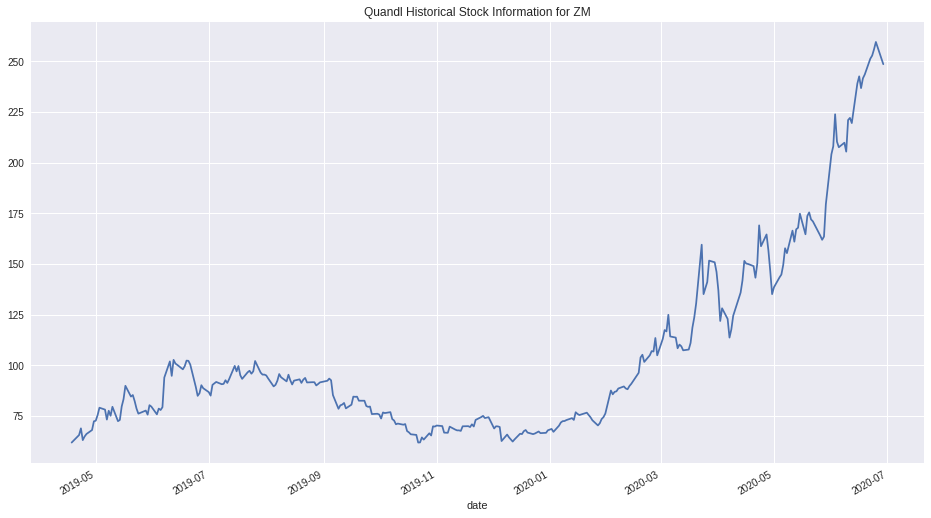

In [12]:
title_string = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=title_string)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [13]:
# Select the data source and pricing columns to use for modeling
# trading_model = stock_yahoo.loc[:, ['Open','Adj Close']]
# trading_model = stock_alpha.loc[:, ['open','adj_close']]
model_template = stock_quandl.loc[:, ['open','close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
if verbose: model_template.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2019-04-18 to 2020-06-29
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   302 non-null    float64
 1   close_price  302 non-null    float64
dtypes: float64(2)
memory usage: 7.1 KB


In [14]:
if verbose: model_template.head()

In [15]:
if verbose: model_template.tail()

### 3.b) Set up the Analysis Table with Indicators

In [16]:
def trading_ma_crossover(model):
    waitfor_first_entry = True
    for x in range(len(model)):
        if model['ma_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should take a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should take a flat position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if waitfor_first_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                waitfor_first_entry = False
            elif (not waitfor_first_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

In [17]:
model_collection = {}
serial_number = 1

for slow_ma in range(slow_ma_min, slow_ma_max+1, ma_increment):
    for fast_ma in range(fast_ma_min, fast_ma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        print('Processing model with slow_ma of', slow_ma, 'and fast_ma of', fast_ma)
        model_name = 'EMA_' + str(serial_number).zfill(3) + '_SlowMA_' + str(slow_ma).zfill(2) + '_FastMA_' + str(fast_ma).zfill(2)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ma'] = trading_model['close_price'].ewm(span=fast_ma).mean()
        trading_model['slow_ma'] = trading_model['close_price'].ewm(span=slow_ma).mean()
        trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        trading_ma_crossover(trading_model)
        model_collection[model_name] = trading_model.copy()
        print('Model', model_name, 'added to the trading model collection.')

Processing model with slow_ma of 10 and fast_ma of 5
Model EMA_001_SlowMA_10_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 5
Model EMA_002_SlowMA_15_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 10
Model EMA_003_SlowMA_15_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 5
Model EMA_004_SlowMA_20_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 10
Model EMA_005_SlowMA_20_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 15
Model EMA_006_SlowMA_20_FastMA_15 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 5
Model EMA_007_SlowMA_25_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 10
Model EMA_008_SlowMA_25_FastMA_10 added to the trading model 

In [18]:
# List the entry/exit points for each model
for key in model_collection:
    print('List the signal change and entry/exit points for', key)
    if verbose: print(model_collection[key][(model_collection[key].signal_change != 0) | (model_collection[key].entry_exit != 0)])
    else: print(model_collection[key][model_collection[key].entry_exit != 0])
    print()

List the signal change and entry/exit points for EMA_001_SlowMA_10_FastMA_05
            open_price  close_price     fast_ma     slow_ma  ma_change  \
date                                                                     
2019-04-22       61.00        65.70   64.220000   64.035000   0.185000   
2019-04-23       66.87        69.00   66.484211   66.030897   0.453314   
2019-05-24       80.48        76.25   80.005400   80.114341  -0.108940   
2019-05-28       76.80        77.77   79.260254   79.686198  -0.425944   
2019-06-07       93.66        94.05   83.760947   81.526427   2.234520   
2019-06-10       98.51       102.00   89.840634   85.251610   4.589025   
2019-06-25       89.43        85.03   92.934637   94.440274  -1.505637   
2019-06-26       87.92        86.33   90.733091   92.965582  -2.232491   
2019-07-10       91.76        92.72   91.134549   90.896458   0.238091   
2019-07-11       92.90        91.40   91.223032   90.988012   0.235021   
2019-08-01       95.75        95.10

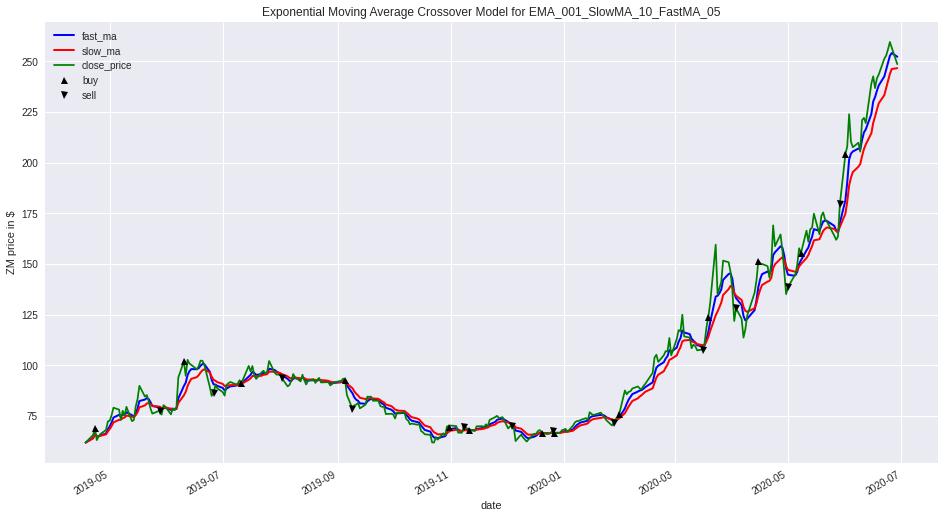

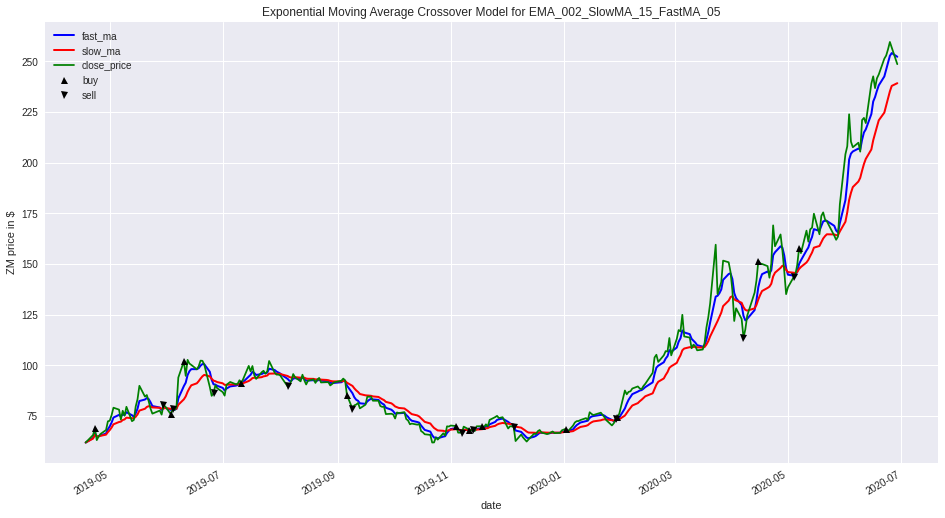

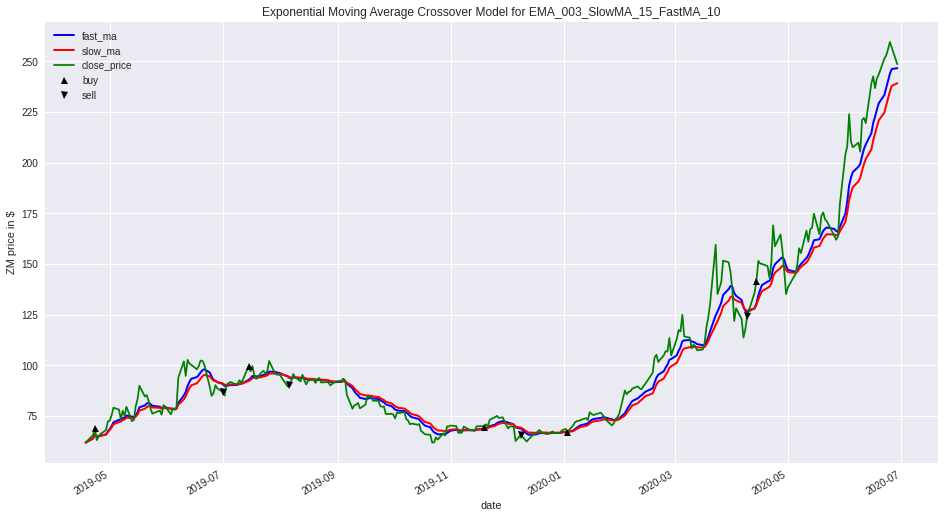

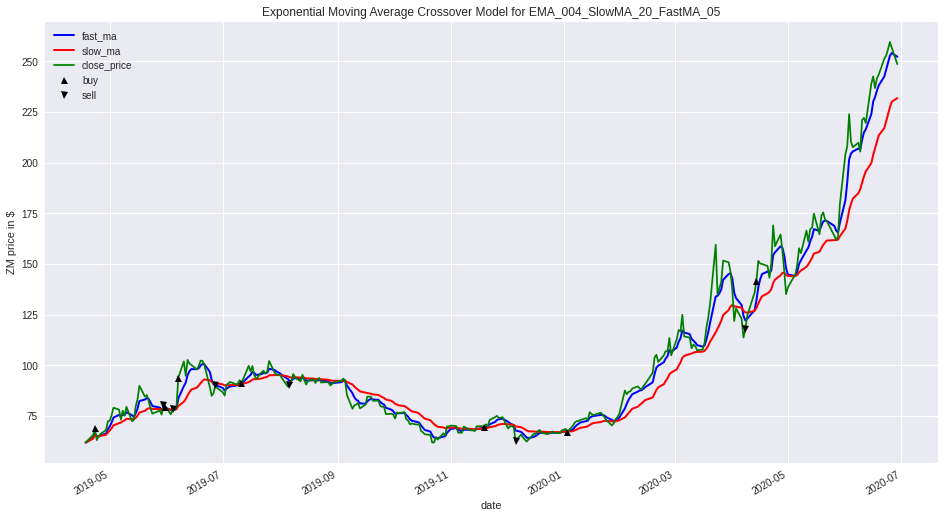

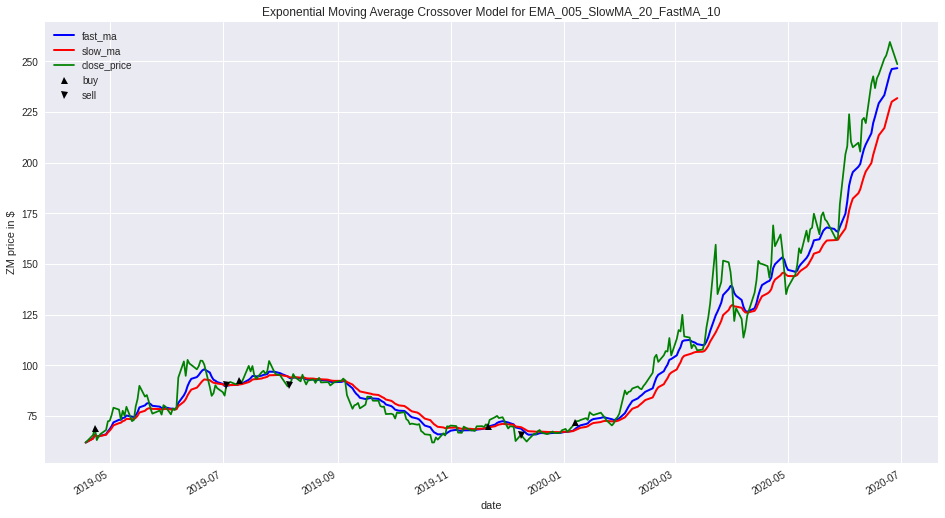

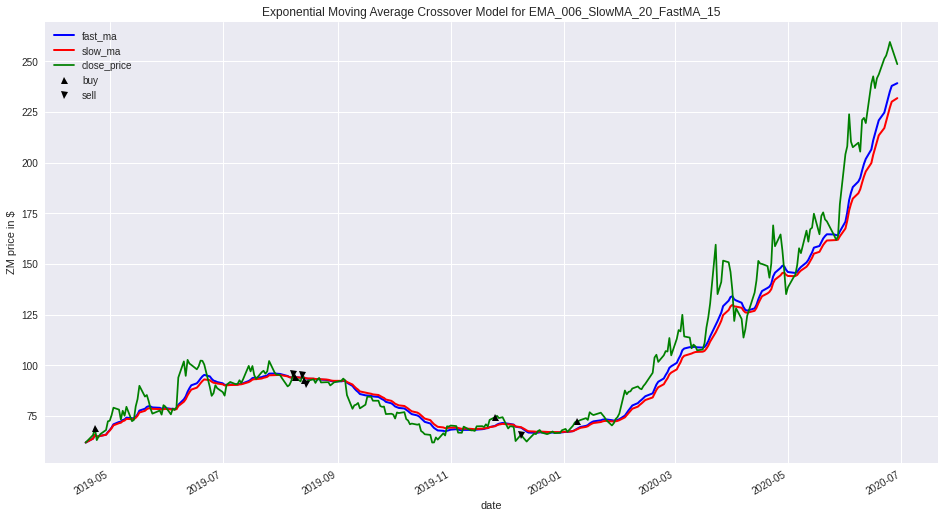

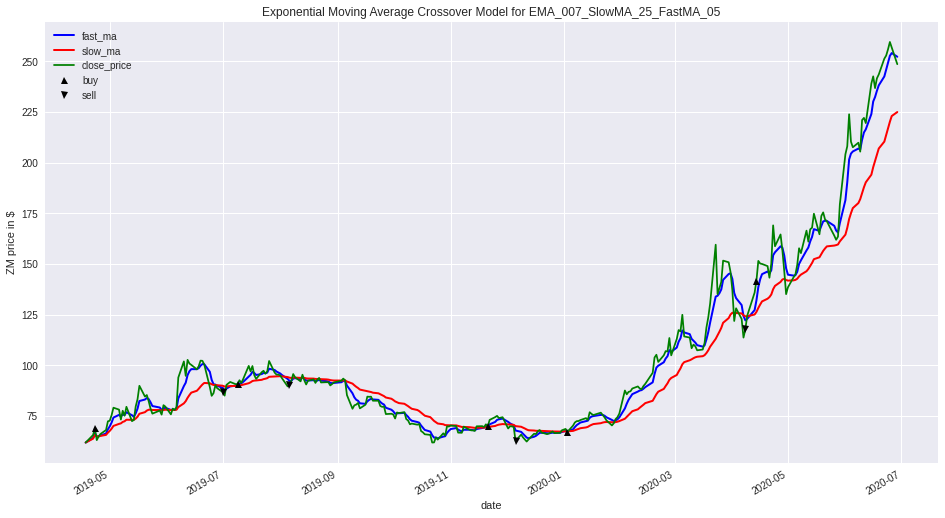

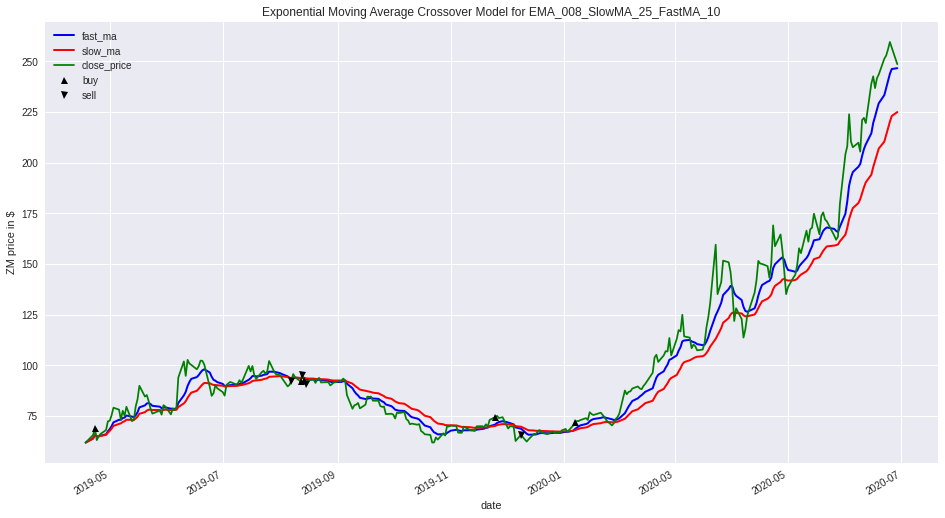

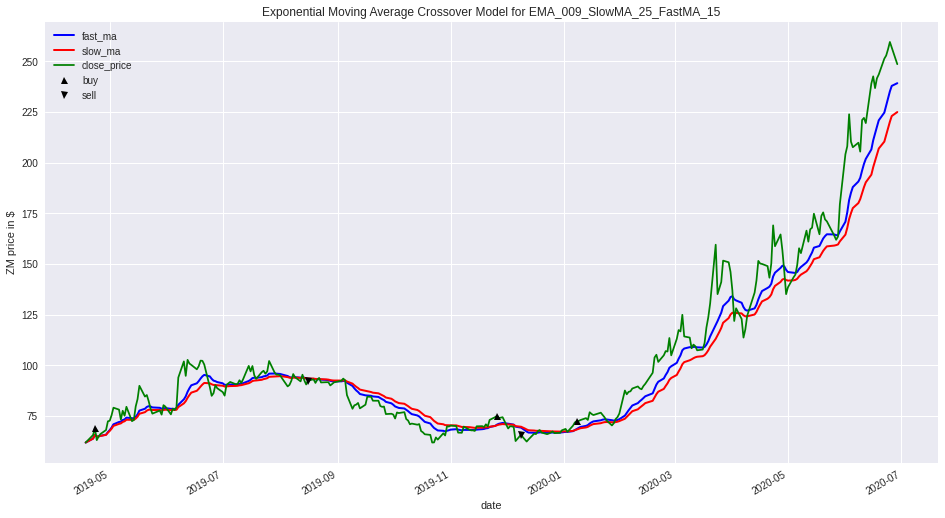

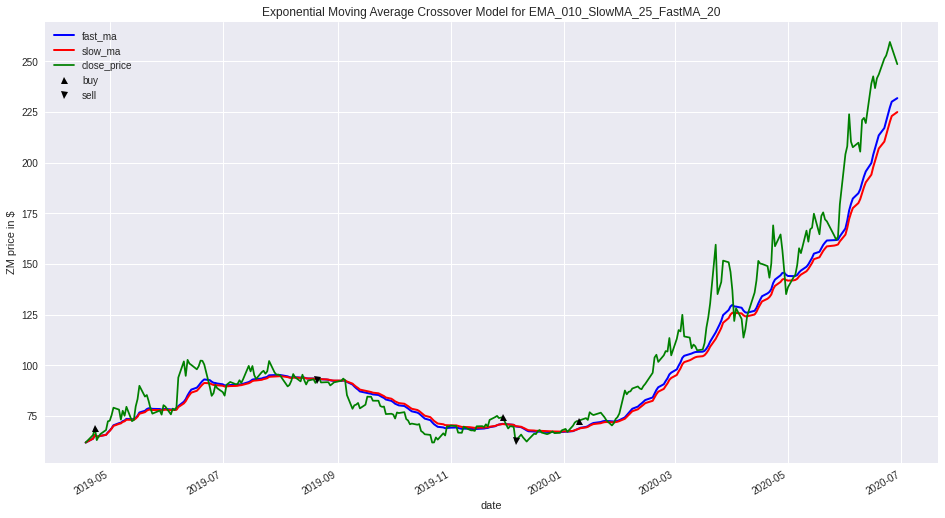

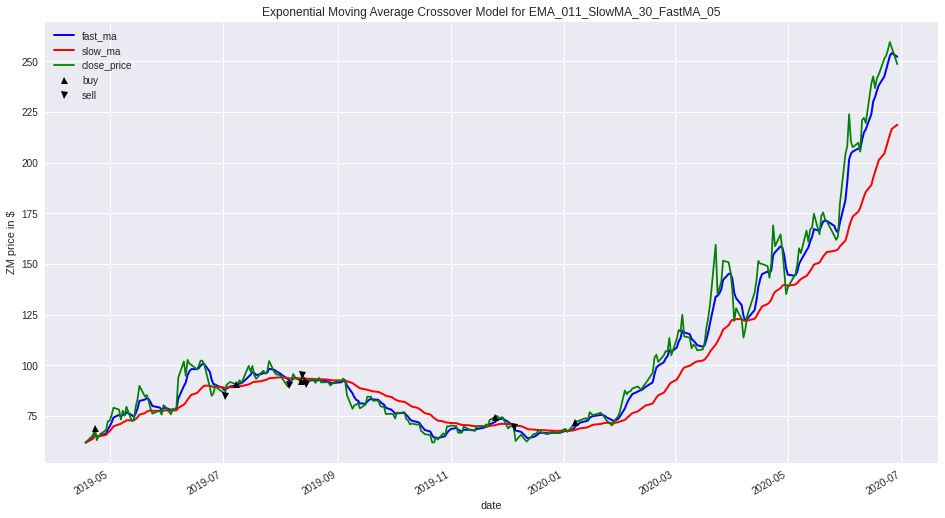

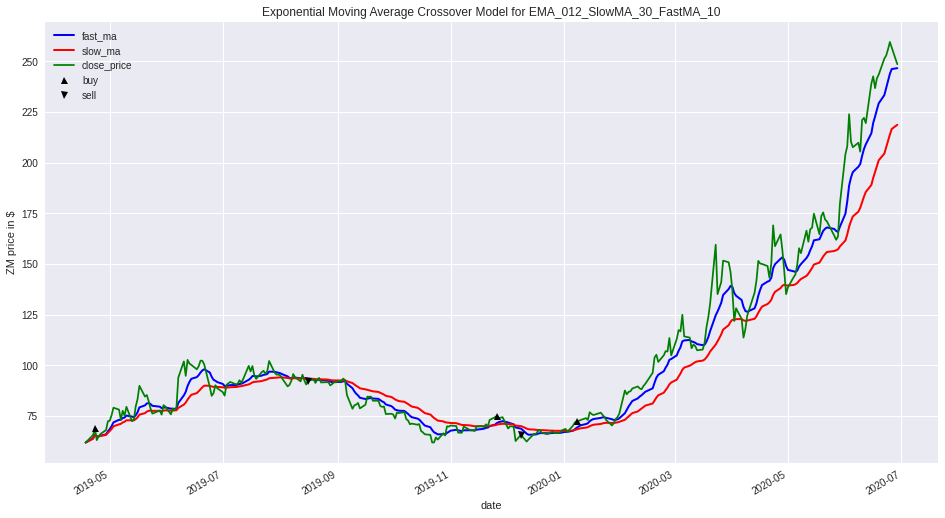

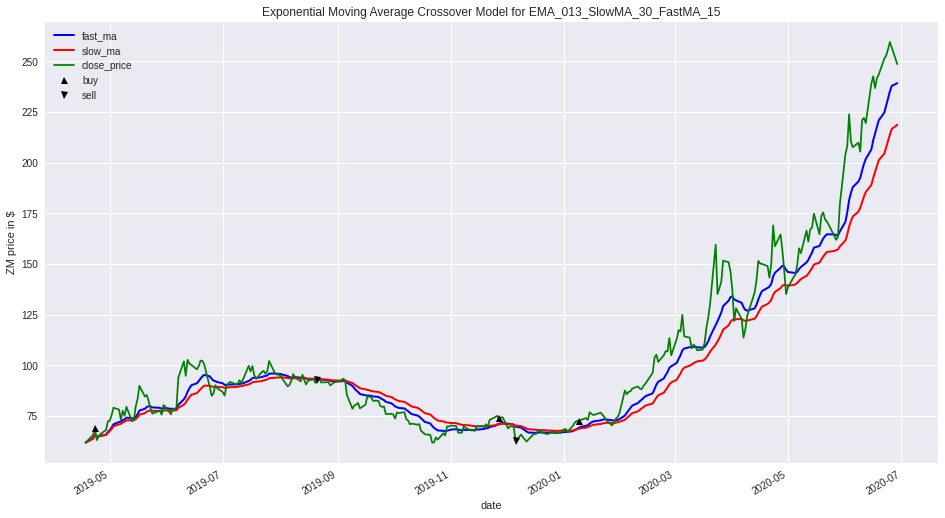

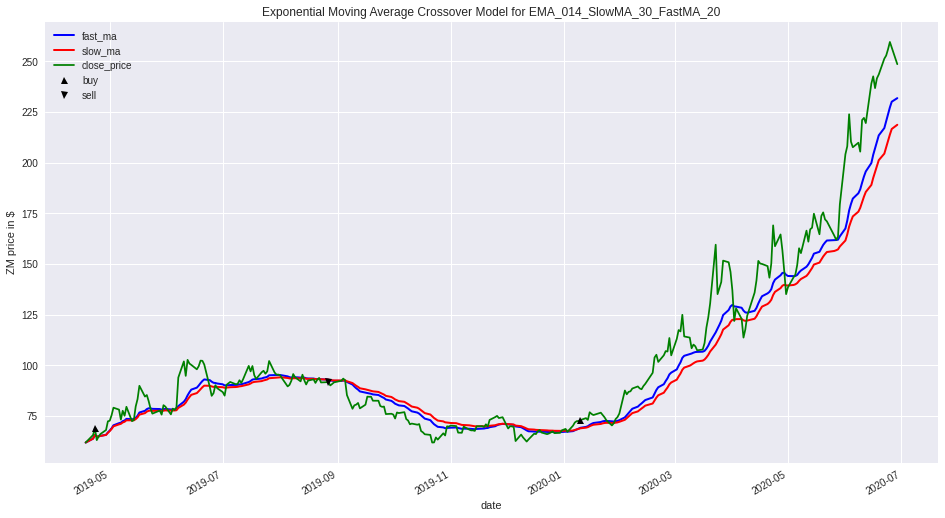

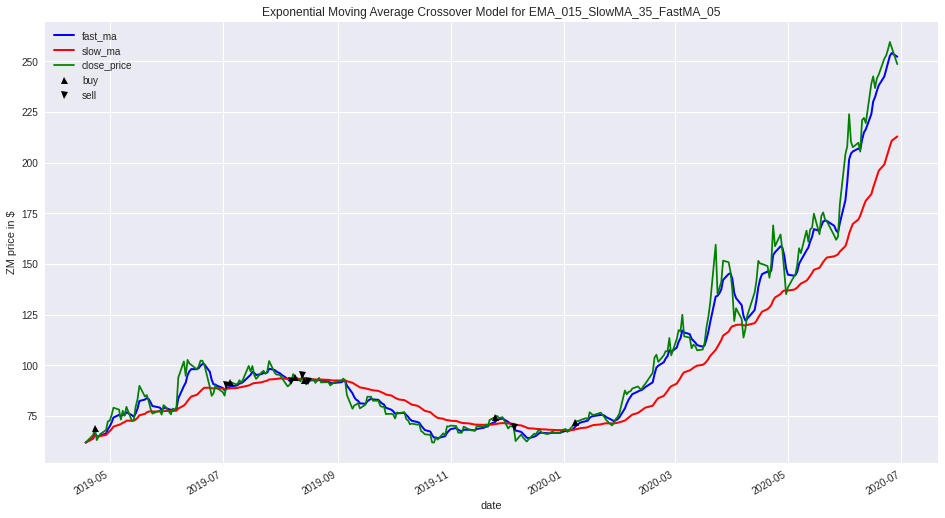

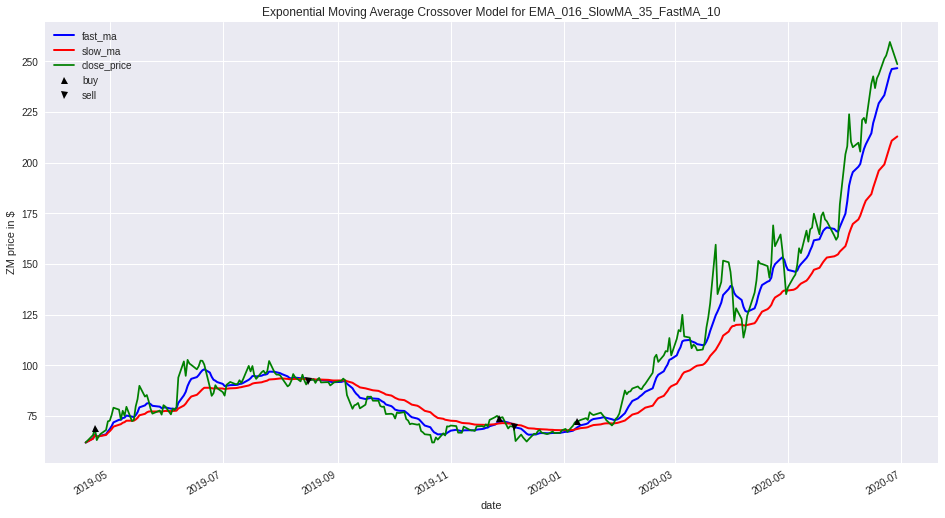

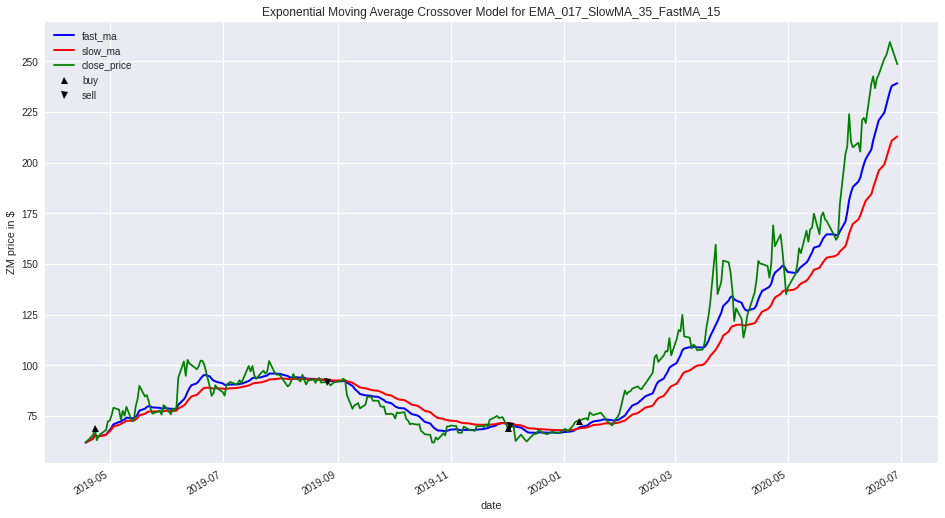

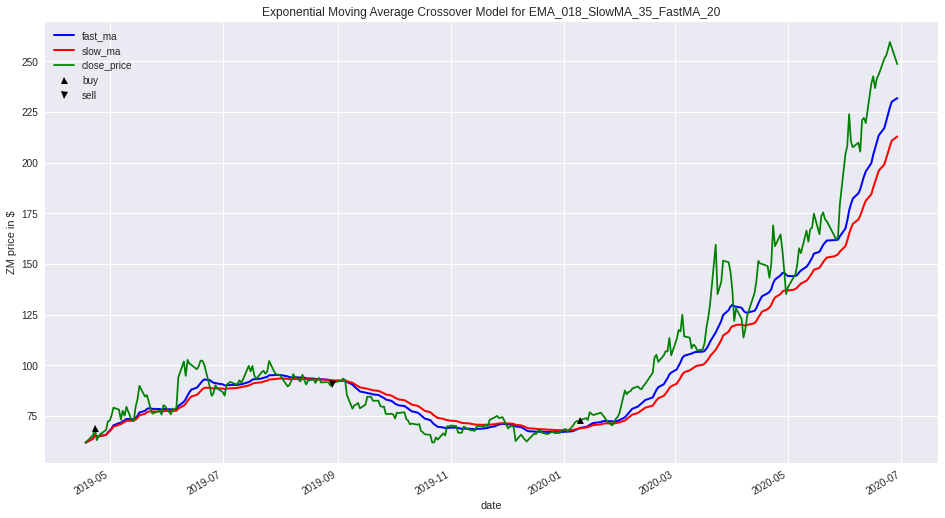

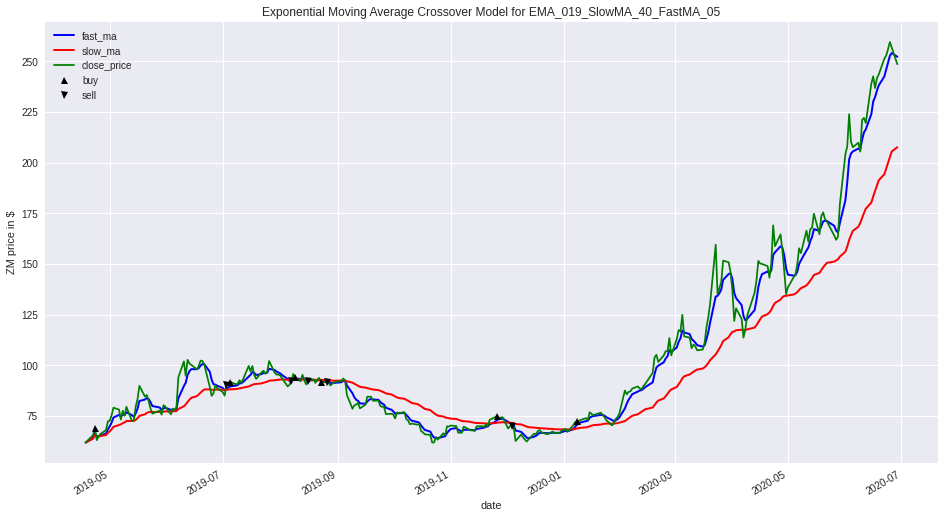

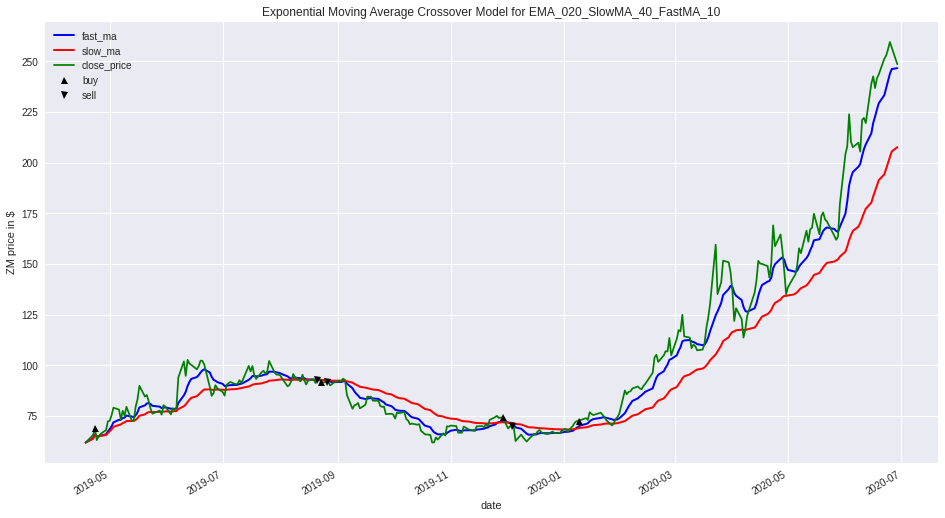

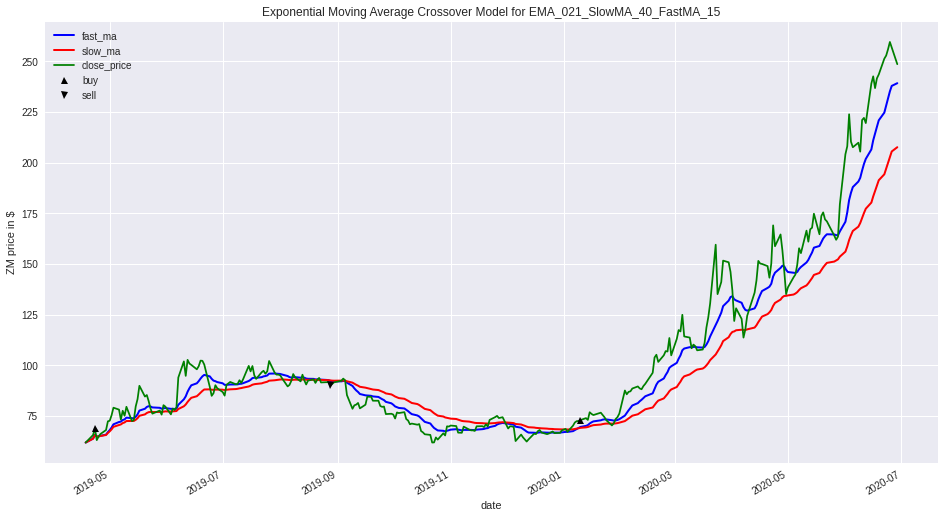

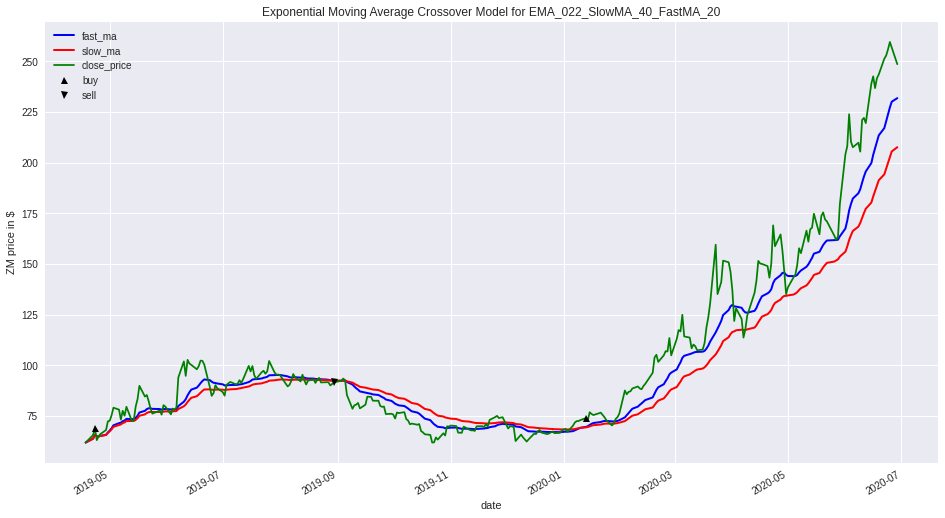

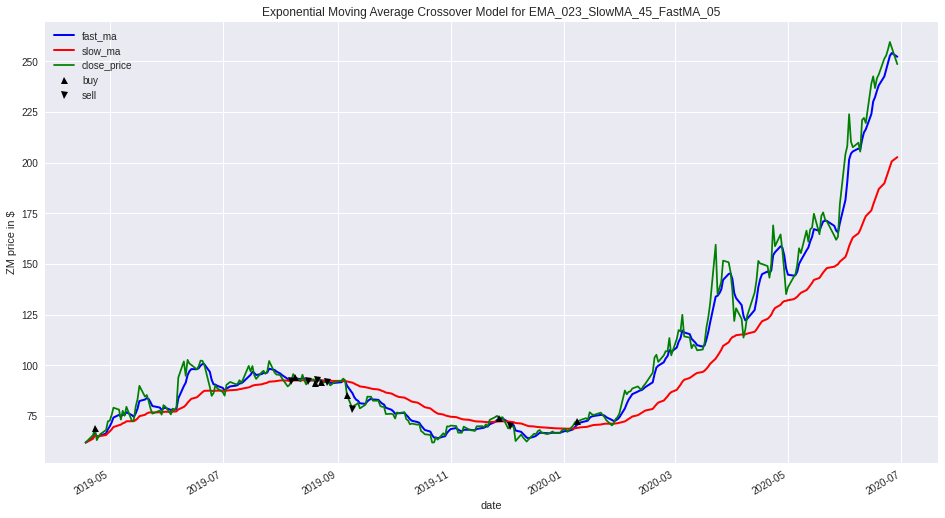

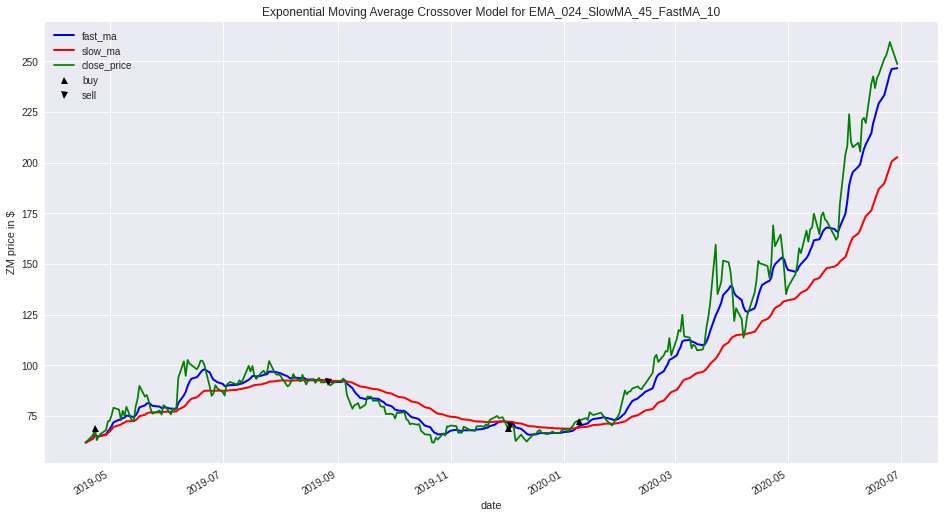

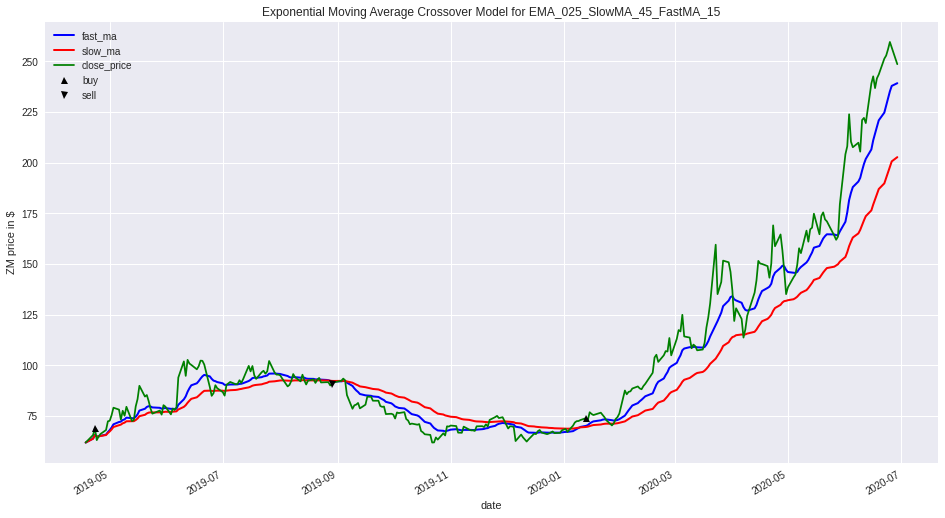

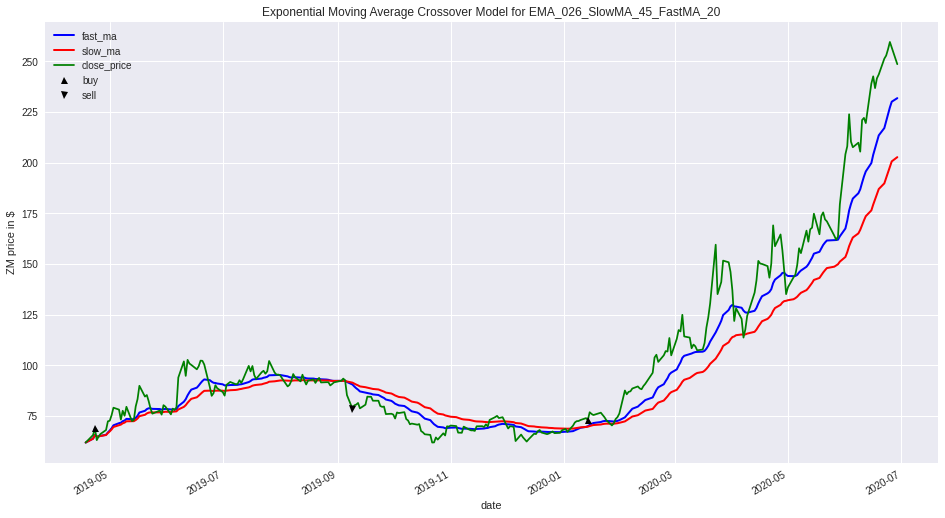

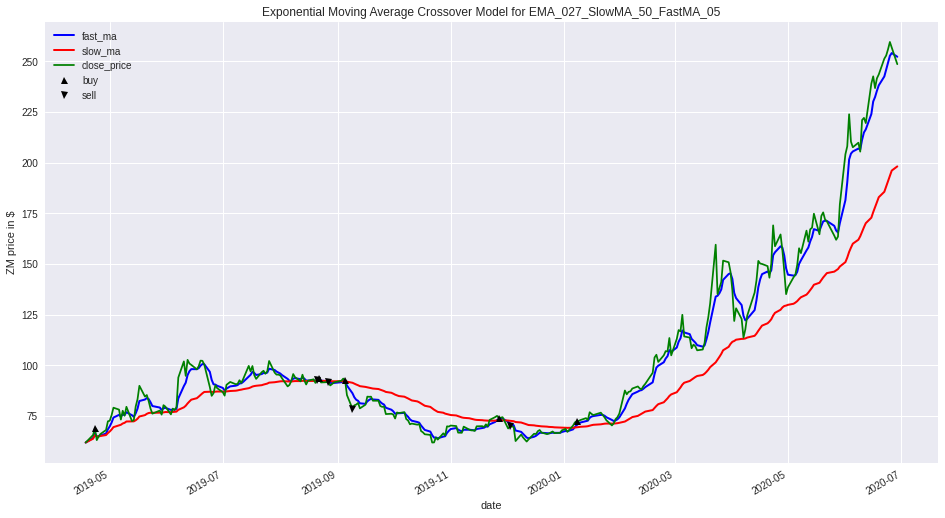

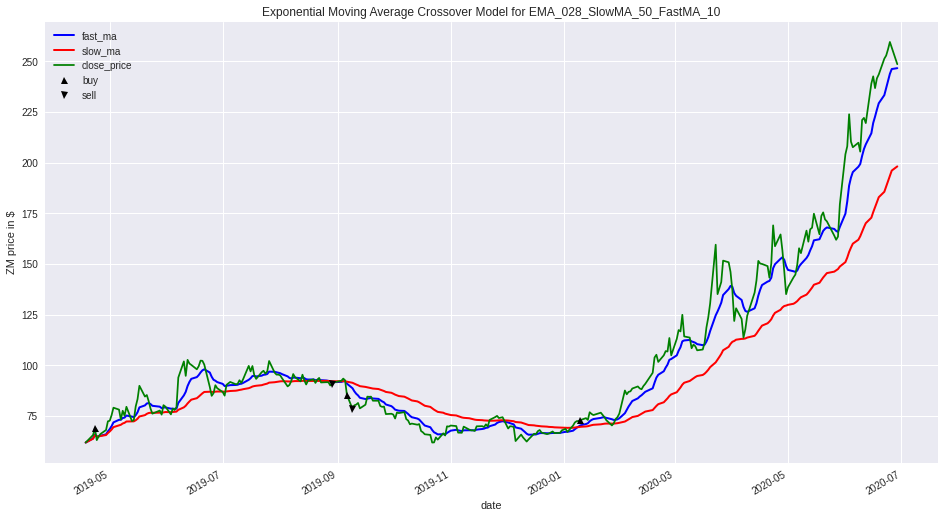

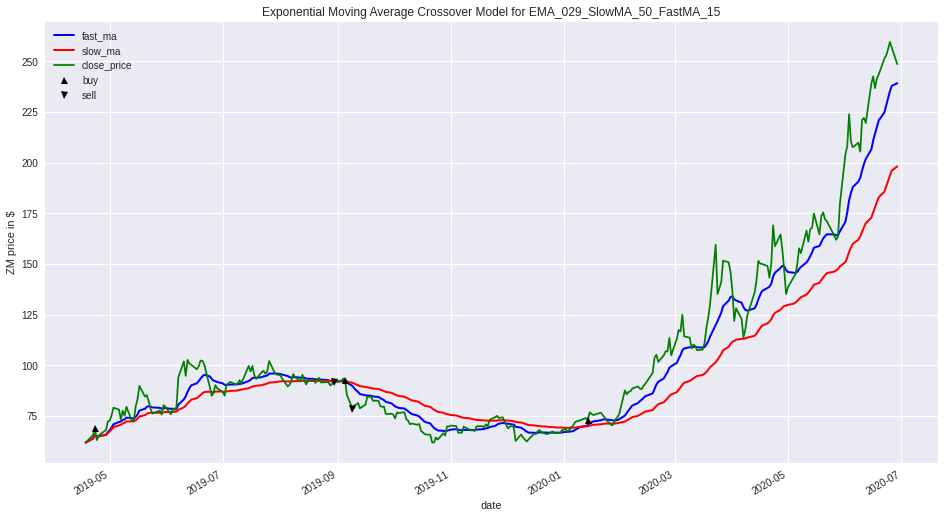

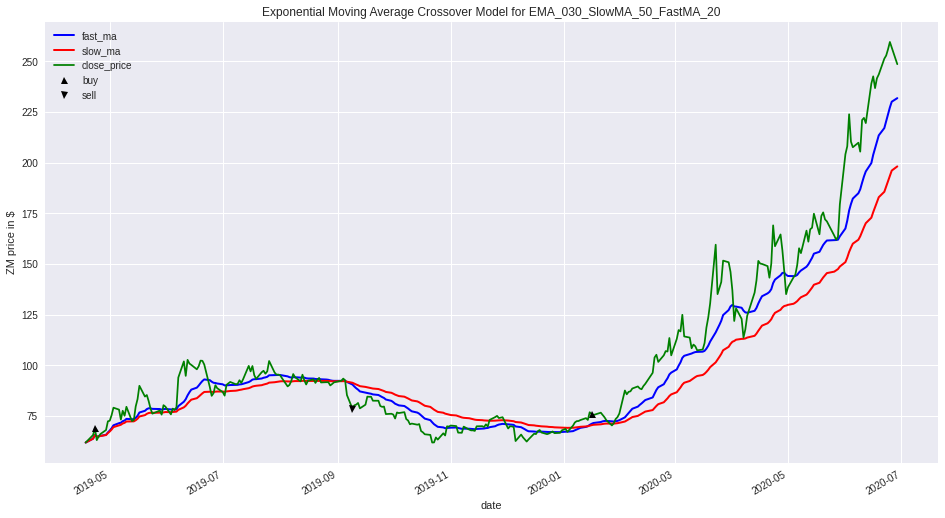

In [19]:
if verbose:
    for key in model_collection:
        graph_data = model_collection[key].copy()
        title_string = "Exponential Moving Average Crossover Model for " + key
        fig = plt.figure(figsize=(16,9))
        ylabel = stock_symbol + ' price in $'
        ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
        graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
        graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
        graph_data['close_price'].plot(ax=ax1, color='g')
        ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
        ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
        plt.legend(loc='upper left')
        plt.show()

## Task 4. Back-test Model

In [20]:
def trading_portfolio_generation(initial_fund, trading_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [21]:
portfolio_collection = {}

# Build dataframe for reporting model performance summary
performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

for key in model_collection:
    print('Processing portfolio for model:', key)
    portfolio_collection[key] = trading_portfolio_generation(initial_capital, model_collection[key])
    trade_transactions = portfolio_collection[key][portfolio_collection[key].trade_action != 0]
    print(trade_transactions)
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[key].accumu_return[-1]))
    if initial_capital != 0:
        return_percentage = portfolio_collection[key].accumu_return[-1] / initial_capital * 100
        print('Accumulated return percentage based on the initial capital investment: %.2f%%' % (return_percentage))
    else:
        return_percentage = None
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
    else:
        print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
    performance_summary = performance_summary.append({'model_name': key, 'return_value': portfolio_collection[key].accumu_return[-1],
                                                      'return_percent': return_percentage}, ignore_index=True)

Processing portfolio for model: EMA_001_SlowMA_10_FastMA_05
BOUGHT QTY: 1 on 2019-04-23 00:00:00 at the price of 66.87
SOLD QTY: -1 on 2019-05-28 00:00:00 at the price of 76.8
BOUGHT QTY: 1 on 2019-06-10 00:00:00 at the price of 98.51
SOLD QTY: -1 on 2019-06-26 00:00:00 at the price of 87.92
BOUGHT QTY: 1 on 2019-07-11 00:00:00 at the price of 92.9
SOLD QTY: -1 on 2019-08-02 00:00:00 at the price of 94.92
BOUGHT QTY: 1 on 2019-09-05 00:00:00 at the price of 94.24
SOLD QTY: -1 on 2019-09-09 00:00:00 at the price of 85.75
BOUGHT QTY: 1 on 2019-10-31 00:00:00 at the price of 69.52
SOLD QTY: -1 on 2019-11-08 00:00:00 at the price of 66.54
BOUGHT QTY: 1 on 2019-11-11 00:00:00 at the price of 69.51
SOLD QTY: -1 on 2019-12-04 00:00:00 at the price of 70.5
BOUGHT QTY: 1 on 2019-12-20 00:00:00 at the price of 68.2
SOLD QTY: -1 on 2019-12-26 00:00:00 at the price of 66.5
BOUGHT QTY: 1 on 2019-12-27 00:00:00 at the price of 67.51
SOLD QTY: -1 on 2020-01-28 00:00:00 at the price of 71.0
BOUGHT QTY

In [22]:
# Display the model performance summary
performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
print(performance_summary)

                     model_name  return_value return_percent
13  EMA_014_SlowMA_30_FastMA_20       201.210           None
17  EMA_018_SlowMA_35_FastMA_20       200.110           None
20  EMA_021_SlowMA_40_FastMA_15       199.770           None
21  EMA_022_SlowMA_40_FastMA_20       199.620           None
24  EMA_025_SlowMA_45_FastMA_15       199.300           None
15  EMA_016_SlowMA_35_FastMA_10       196.220           None
19  EMA_020_SlowMA_40_FastMA_10       196.150           None
27  EMA_028_SlowMA_50_FastMA_10       193.860           None
25  EMA_026_SlowMA_45_FastMA_20       193.120           None
23  EMA_024_SlowMA_45_FastMA_10       192.960           None
16  EMA_017_SlowMA_35_FastMA_15       192.690           None
10  EMA_011_SlowMA_30_FastMA_05       192.540           None
9   EMA_010_SlowMA_25_FastMA_20       190.720           None
28  EMA_029_SlowMA_50_FastMA_15       190.700           None
29  EMA_030_SlowMA_50_FastMA_20       189.440           None
11  EMA_012_SlowMA_30_Fa

In [23]:
# Display the transactions from the top model
top_model = performance_summary.iloc[0]['model_name']
print('The transactions from the top model %s:' % (top_model))
print(portfolio_collection[top_model][portfolio_collection[top_model].trade_action != 0])

The transactions from the top model EMA_014_SlowMA_30_FastMA_20:
           trade_action qty_onhand cost_basis sold_transaction gain_loss  \
date                                                                       
2019-04-23            1          1      66.87                0         0   
2019-08-27           -1          0          0             92.6     25.73   
2020-01-10            1          1      73.08                0         0   

           cash_onhand position_value total_position accumu_return  
date                                                                
2019-04-23      -66.87             69           2.13          2.13  
2019-08-27       25.73              0          25.73         25.73  
2020-01-10      -47.35          73.09          25.74         25.74  


In [24]:
# Display the entry and exit signals for the top model
print('The trading signal changes from the top model %s:' % (top_model))
print(model_collection[top_model][model_collection[top_model].signal_change != 0])

The trading signal changes from the top model EMA_014_SlowMA_30_FastMA_20:
            open_price  close_price    fast_ma    slow_ma  ma_change  \
date                                                                   
2019-04-22       61.00        65.70  63.942500  63.911667   0.030833   
2019-08-26       92.33        91.76  93.059879  93.091478  -0.031599   
2020-01-09       73.99        72.62  68.861844  68.743293   0.118551   

            trade_signal  signal_change  entry_exit  
date                                                 
2019-04-22           1.0            1.0         0.0  
2019-08-26           0.0           -1.0         0.0  
2020-01-09           1.0            1.0         0.0  


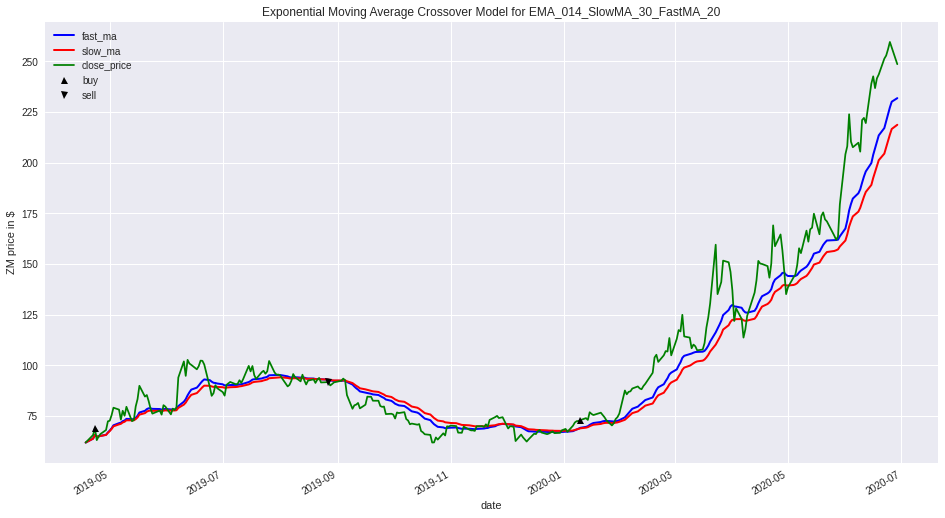

In [25]:
graph_data = model_collection[top_model].copy()
title_string = "Exponential Moving Average Crossover Model for " + top_model
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g')
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend(loc='upper left')
plt.show()

## Task 5. Evaluate Performance

In [26]:
best_model = ''
best_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] > best_return:
        best_model = key
        best_return = portfolio_collection[best_model]['accumu_return'][-1]
print('The best model found is:', best_model)
print('The best profit/loss for the investing period is: $%.2f' % (best_return))
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (best_return / initial_capital * 100))

The best model found is: EMA_014_SlowMA_30_FastMA_20
The best profit/loss for the investing period is: $201.21


In [27]:
worst_model = None
worst_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] < worst_return:
        worst_model = key
        worst_return = portfolio_collection[worst_model]['accumu_return'][-1]
print('The worst model found is:', worst_model)
print('The worst profit/loss for the investing period is: $%.2f' % (worst_return))
if initial_capital != 0:
    print('The worst return percentage for the initial capital is: %.2f%%' % (worst_return / initial_capital * 100))

The worst model found is: None
The worst profit/loss for the investing period is: $0.00


In [28]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $183.56


In [29]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:38.476438
